# Predictive Model for Forecasting Smoke Estimate
**Goal**:   
You should develop a predictive model based on the fire data and smoke estimate for your assigned city. Your model should predict smoke estimates for every year for the next 25 years (i.e., 2025-2050). You should be careful to make sure your predictions convey appropriate levels of uncertainty in the prediction.


## License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 16, 2024

The rest of the code lies under the standard MIT license.

#### External Libraries

Uncomment the below cell to install and import the external dependencies from the following libraries - 
1. `pandas`
2. `numpy`
3. `matplotlib`
4. `sklearn`

In [ ]:
# ! pip install pandas
# !pip install numpy
# ! pip install matplotlib
# ! pip install sklearn
# !pip install statsmodels

In [46]:
#
# Import necessary libraries
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

### Dataframe Manipulation to Build a Time Series Forecasting Model

I plan to use multiple variables - including the ones from the wildfire data that we extracted using the API in the `data_acquisation.ipynb` notebook. 
Hence, let's pull up that dataframe here.

In [54]:
wildfire_df_within_650_miles = pd.read_csv("wildfire_df_within_650_miles.csv")
wildfire_df_within_650_miles.head()

,Unnamed: 0.1,Unnamed: 0,OBJECTID,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,...,Listed_Fire_Causes,Listed_Fire_Cause_Class,Listed_Rx_Reported_Acres,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Shape_Length,Shape_Area,Min_Distance_Miles
0,5,5,14605,14605,Wildfire,1964,1,"1 (2), 3 (4)",14101.443662,5706.651785,...,Human (2),"Undetermined (4), Human (2)",NaN,NaN,NaN,0.245135,NaN,54086.991380,5.706652e+07,286.730967
1,7,7,14607,14607,Wildfire,1964,1,"1 (1), 3 (1)",11131.171732,4504.625381,...,NaN,Undetermined (2),NaN,NaN,NaN,0.323658,NaN,41820.660908,4.504625e+07,585.560801
2,8,8,14608,14608,Wildfire,1964,1,"1 (1), 3 (2)",10817.550376,4377.707322,...,Unknown (2),Undetermined (3),NaN,NaN,NaN,0.166330,NaN,57509.990144,4.377707e+07,500.558777
3,13,13,14613,14613,Wildfire,1964,1,"1 (1), 3 (3)",5876.966587,2378.323998,...,Unknown (3),Undetermined (4),NaN,NaN,NaN,0.169715,NaN,41964.322535,2.378324e+07,617.031596
4,14,14,14614,14614,Wildfire,1964,1,"1 (1), 3 (1)",4996.316663,2021.937618,...,NaN,Undetermined (2),NaN,NaN,NaN,0.994810,1.0,15981.540700,2.021938e+07,249.754960


I want to create a "annual average" for each of the numerical columns I'm interested in - `GIS_Acres`, `Shape_Length`, `Shape_Area`, `Assigned_Fire_Type` and `Circleness_Scale`. These were predominantely the factors I used in formulating the smoke estimate in the `smoke_estimate.ipynb` notebook.


This code groups the data by Fire_Year to calculate yearly averages for key wildfire metrics. 

In [89]:
wildfire_df_within_650_miles_grouped = wildfire_df_within_650_miles.groupby('Fire_Year').agg({
    'GIS_Acres': 'mean',
    'Shape_Length': 'mean',
    'Shape_Area': 'mean',
    'Circleness_Scale': 'mean',
}).reset_index()
wildfire_df_within_650_miles_grouped.head()

,Fire_Year,GIS_Acres,Shape_Length,Shape_Area,Circleness_Scale
0,1964,821.411743,6281.134037,3.324135e+06,0.692731
1,1965,455.814435,4570.249877,1.844616e+06,0.623732
2,1966,2078.120464,9356.220102,8.409855e+06,0.671092
3,1967,322.390035,2970.186385,1.304666e+06,0.772353
4,1968,479.643100,4160.062377,1.941047e+06,0.640985


Now, since we have the wilidfire data in a suitable format from our analysis, let's join it with the smoke estimate data generated in `smoke_estimate.ipynb` using the `Year` column.

In [77]:
#
# Reading the smoke estimate CSV file
#
smoke_estimate_df = pd.read_csv("smoke_estimate_data.csv")
smoke_estimate_df.head()

,Unnamed: 0,total_impact,peak_daily_impact,num_fires,total_acres,average_impact_per_fire,impact_density,Year,smoke_estimate
0,0,537.607046,0.294440,138,113354.820507,3.895703,0.004743,1964,0.027160
1,1,235.333729,0.117670,100,45581.443461,2.353337,0.005163,1965,0.002361
2,2,495.438609,0.279405,170,353280.478901,2.914345,0.001402,1966,0.023701
3,3,312.113945,0.212278,98,31594.223456,3.184836,0.009879,1967,0.008660
4,4,206.553770,0.155622,85,40769.663532,2.430044,0.005066,1968,0.000000


In [90]:
merged_smoke_estimate_df = pd.merge(smoke_estimate_df, wildfire_df_within_650_miles_grouped, left_on='Year', right_on='Fire_Year', how='inner')
merged_smoke_estimate_df = merged_smoke_estimate_df[['Fire_Year', 'peak_daily_impact', 'num_fires', 'smoke_estimate', 'GIS_Acres', 'Shape_Length', 'Shape_Area', 'Circleness_Scale']]
merged_smoke_estimate_df.head()

,Fire_Year,peak_daily_impact,num_fires,smoke_estimate,GIS_Acres,Shape_Length,Shape_Area,Circleness_Scale
0,1964,0.294440,138,0.027160,821.411743,6281.134037,3.324135e+06,0.692731
1,1965,0.117670,100,0.002361,455.814435,4570.249877,1.844616e+06,0.623732
2,1966,0.279405,170,0.023701,2078.120464,9356.220102,8.409855e+06,0.671092
3,1967,0.212278,98,0.008660,322.390035,2970.186385,1.304666e+06,0.772353
4,1968,0.155622,85,0.000000,479.643100,4160.062377,1.941047e+06,0.640985


Now we have everything we need to build our predictive model!

## Deciding on what Model to Build.

The primary objective is to create a model that can accurately predict smoke estimate changes over time, particularly during wildfire months. Given that our data spans several years, it's essential to account for temporal changes and underlying trends that could impact smoke estimate forecasts. Below, we consider different model options before settling on a solution that best aligns with our requirements.

### 2. **Model Options**

1. **Regression Model?**
   - A multiple linear regression model is suitable for establishing relationships between smoke estimates and other variables, but it doesn’t inherently account for temporal dependencies. Since smoke estimate trends evolve over time, a simple regression model would likely miss these temporal patterns, making it suboptimal for this case.

2. **Time Series Model?**
   - Time series models, which incorporate past data points, seem more appropriate for our objective of capturing smoke estimate trends. However, an initial analysis using a basic time series model in the `smoke_estimate.ipynb` notebook revealed a mismatch between our smoke estimate predictions and actual smoke trends. While the general patterns aligned, noticeable discrepancies suggest that smoke estimates are influenced by more than just historical values—other external variables, like wildfire data, could provide additional predictive power.

### Solution: ARIMAX
 **Rationale:** An ARIMAX (AutoRegressive Integrated Moving Average with Exogenous Variables) model combines the strengths of both time series and regression models, integrating external variables (like wildfire data) into the temporal forecasting framework. This approach would allow us to capture both the temporal patterns of smoke estimates and the impact of external factors that may influence these levels. By using wildfire data as an additional variable, we aim to improve smoke estimate predictions by accounting for the influence of smoke and fire on air quality.  

ARIMAX extends the ARIMA model, which combines autoregression, differencing, and moving averages, by allowing additional (exogenous) variables to inform the forecast. The autoregressive (AR) part considers past smoke estimate values, while the moving average (MA) part helps smooth fluctuations. The exogenous variables (in this case, wildfire data) allow the model to incorporate additional influences on smoke estimates.  

ARIMAX is particularly advantageous when external factors are known to affect the target variable over time, making it well-suited to capture both smoke estimate seasonality and the impact of wildfire data in a single, cohesive model.

**What about Seasonality?**
Given that our data primarily spans wildfire months, traditional seasonal adjustments may not be necessary. These months already concentrate much of the smoke estimate variation driven by wildfire activity, so including seasonality explicitly might add unnecessary complexity.

** But aren't we using the same Data for Estimation and Forecasting**
While we’re using the same wildfire data both to create initial smoke estimates and as additional ARIMAX variables, this is intentional. The wildfire data can reveal smoke-impacting trends that aren’t fully captured by the initial estimates alone, potentially improving the model’s forecasting accuracy. Adding these variables is a strategic choice to capture influences on smoke estimates that our formula-based estimates may miss, ultimately aiming to enhance the predictive power of our model. 

## Comparing ARIMA vs ARIMAX

I suspected that an ARIMA model might fall short in fully capturing the trends needed for an accurate forecast. To verify this, we’ll build an ARIMA model using the smoke estimates calculated in `smoke_estimates.ipynb` and forecast from 2020 to 2050.

**Quick Overview of ARIMA:**  
ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that combines three elements:
- **AutoRegression (AR):** Uses past values of the series to predict future values.
- **Integrated (I):** Differencing of observations to make the data stationary.
- **Moving Average (MA):** Uses past forecast errors in a regression-like model to smooth out fluctuations.  

This model is often effective for univariate time series, though it may need additional external variables to capture more complex patterns.

**Train-Test Split**:
The data is then divided into training and testing sets. The training set (`train_df`) includes all records from years before 2015, while the testing set (`test_df`) consists of records from 2015 and onward. This division allows the model to be trained on historical data before being evaluated on more recent, unseen data.

An ARIMA model is instantiated using the training set's smoke estimates with a specified order of (2, 1, 2). This order indicates:  
- **2:** Number of lagged observations in the model (AR component).  
- **1:** Degree of differencing to make the series stationary (I component).  
- **2:** Number of lagged forecast errors to include (MA component).  

This combination of the AR, I, and MA was determined through a series of trial and error and iterating through multiple combinations of these values.

After fitting the model, predictions are generated for the test set period, extending from the end of the training data. 

Finally, the code computes the Mean Squared Error (MSE) between the actual values in the test set (`test_df['smoke_estimate']`) and the predicted values (`arima_pred`)

In [91]:
# Extract relevant columns from the merged smoke estimate DataFrame.
arima_df = merged_smoke_estimate_df[['Fire_Year', 'smoke_estimate']]

# Use data before 2015 for training and data from 2015 onwards for testing.
train_df = arima_df[arima_df['Fire_Year'] < 2015]  # Training set
test_df = arima_df[arima_df['Fire_Year'] >= 2015]  # Testing set

# Create an ARIMA model with the specified order (2, 1, 2).
# - 2: Number of lagged obsddervations (AR component).
# - 1: Degree of differencing to make the series stationary (I component).
# - 2: Number of lagged forecast errors (MA component).
arima_model = ARIMA(train_df['smoke_estimate'], order=(2, 1, 2))
arima_result = arima_model.fit()  # Fit the model to the training data

# Predict smoke estimates for the test set period, starting from the end of the training data.
arima_pred = arima_result.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, typ='levels')

# Calculate Mean Squared Error (MSE) to assess the accuracy of the predictions.
# This compares the actual values in the test set to the predicted values from the model.
arima_mse = mean_squared_error(test_df['smoke_estimate'], arima_pred)

In [92]:
print("The MSE for the ARIMA model:", arima_mse)

The MSE for the ARIMA model: 0.017132992448572016


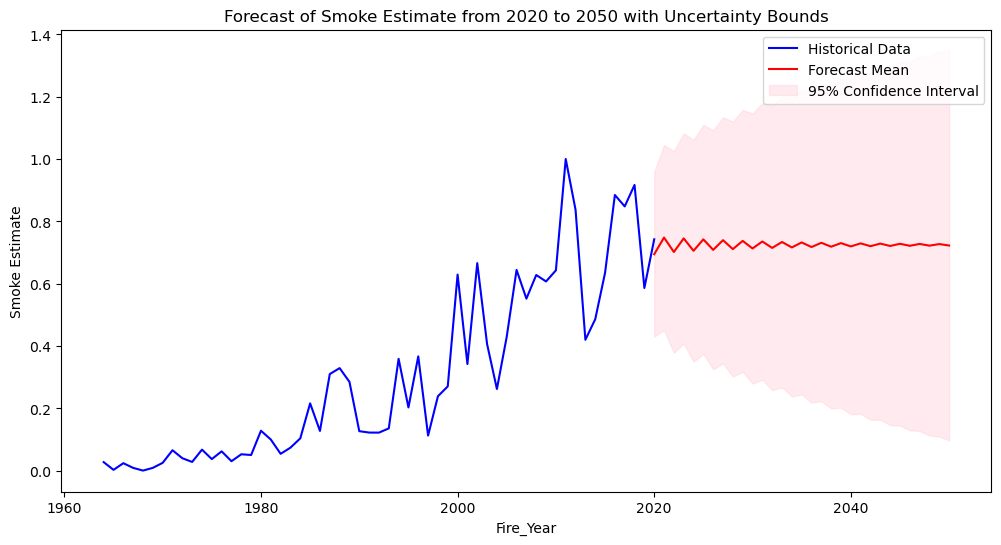

In [93]:
# Specify the range of years for which we want to forecast smoke estimates (from 2020 to 2050).
forecast_years = range(2020, 2051)
n_forecasts = len(forecast_years)  # Calculate the number of forecasted years

# Fit an ARIMA model to the historical total impact data using the specified order (2, 1, 2).
forecast_result = ARIMA(arima_df['smoke_estimate'], order=(2, 1, 2)).fit()

# Use the fitted model to forecast the total impact for the specified number of future steps.
forecast = forecast_result.get_forecast(steps=n_forecasts)
forecast_mean = forecast.predicted_mean  # Extract the predicted mean values
forecast_conf_int = forecast.conf_int(alpha=0.05)  # Get the 95% confidence intervals for the forecast

# Create a line plot to visualize the historical data and the forecast results, including confidence intervals.
plt.figure(figsize=(12, 6))
plt.plot(arima_df['Fire_Year'], arima_df['smoke_estimate'], label='Historical Data', color='blue')
plt.plot(forecast_years, forecast_mean, label='Forecast Mean', color='red') 
plt.fill_between(forecast_years, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval') 
plt.title("Forecast of Smoke Estimate from 2020 to 2050 with Uncertainty Bounds")  
plt.xlabel("Fire_Year") 
plt.ylabel("Smoke Estimate")  
plt.legend() 
plt.show() 

### Analysis of the ARIMA Forecast

This graph above shows the **time series forecast** for smoke estimates, including a prediction range extending from 2020 to 2050. 

The blue line on the left side of the graph shows the **actual smoke estimate data** from past years, leading up to 2020. It indicates how smoke levels have varied over time, showing periods of fluctuation. From about 1980 onwards, we see a general upward trend, with smoke estimates becoming more variable and peaking at certain points.

The red line starting around 2020 represents the **forecasted average** smoke estimate for future years, based on the ARIMA model. This line is flat, which suggests the model expects future smoke levels to stay relatively stable at this average level. However, this flat trend might indicate that the model isn’t capturing any potential future increases or decreases effectively, especially given the past data's fluctuation and trend changes.

The pink shaded area around the red line is the **95% confidence interval** for the forecast. This interval represents the model's uncertainty about the forecasted values. In simple terms, it’s the range within which the true smoke estimate values are likely to fall 95% of the time. The confidence interval gets wider over time, especially as it moves further into the future (up to 2050). This widening indicates that the model is less certain about smoke estimates as time progresses, which is typical in long-term forecasting.


We generally evaluate the model's performance using the **Mean Squared Error (MSE)**, which in this case is about **0.017**. Since the data ranges from **0 to 1**, this MSE value is relatively small. This suggests that the model’s predictions are fairly close to the actual values in the testing period (2015–2020). However, I'm concerned that the flat trend in the forecast mean indicates the model might not fully capture potential future trends or changes in smoke levels. If smoke levels are likely to increase or decrease due to external factors (e.g., climate change, changes in fire management practices), a model with a flat trend might be too simplistic.

## ARIMAX Forecasting
This below code forecasts future values of smoke estimated from 2021 to 2050 using the ARIMAX model.

As discussed previously, we are introducing "exogenous variables." These variables include factors like the acreage burned and number of fires, which could contribute to smoke impact.

A model is created using historical data up to 2020, which captures patterns in "smoke_estimate" and relationships with the other influencing variables. This model can then predict future values based on these learned patterns. The code forecasts future values from 2021 to 2050. For this, it estimates future values for each influencing variable using recent trends. These projected values are then fed into the model to predict "smoke_estimate" for each year.

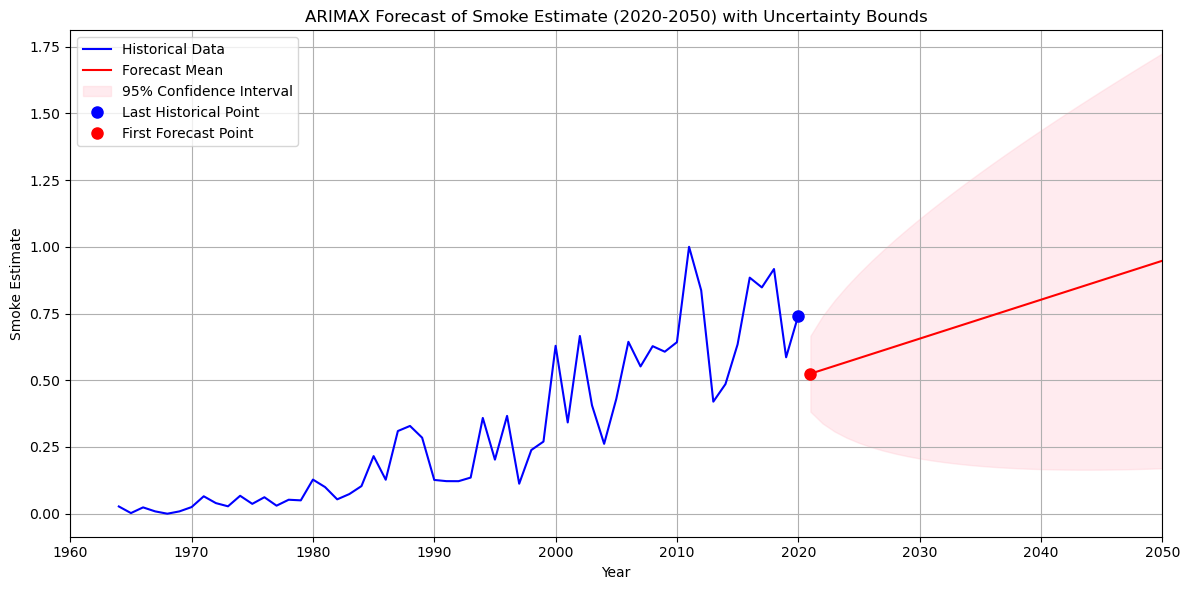

In [99]:
# Sort the data by year to ensure it's in chronological order
merged_smoke_estimate_df = merged_smoke_estimate_df.sort_values('Fire_Year')

# Prepare the "endogenous" variable, which is the main data we're analyzing (in this case, "smoke_estimate"),
# and the "exogenous" variables, which are additional data points that may influence "smoke_estimate".
endog = merged_smoke_estimate_df['smoke_estimate']
exog = merged_smoke_estimate_df[['GIS_Acres', 'Shape_Length', 'Shape_Area', 'Circleness_Scale',
                                 'peak_daily_impact', 'num_fires']]

# Create training and testing sets based on the year, with data before 2015 for training 
# and data from 2015 onwards for testing.
train_mask = merged_smoke_estimate_df['Fire_Year'] < 2015
test_mask = merged_smoke_estimate_df['Fire_Year'] >= 2015
train_endog = endog[train_mask]
train_exog = exog[train_mask]
test_endog = endog[test_mask]
test_exog = exog[test_mask]

# Fit a time series model using the best determined order (stored in "best_order") on the entire dataset.
# The model attempts to capture patterns in the "smoke_estimate" data while also considering the influence
# of exogenous variables.
model = SARIMAX(endog, exog=exog, order=best_order).fit()

# Create a DataFrame to hold future years (2021-2050) for which we want to make predictions.
# This assumes the original data ends in 2020.
future_years_index = np.arange(2021, 2051)
future_years = pd.DataFrame(index=future_years_index)

# For each exogenous variable (additional influencing data), estimate a trend based on the last 10 years.
# This trend is then used to extrapolate values for the years 2021 to 2050.
for col in exog.columns:
    # Take the last 10 years of data for each variable to calculate the trend.
    recent_data = merged_smoke_estimate_df.tail(10)
    z = np.polyfit(recent_data['Fire_Year'], recent_data[col], 1)
    p = np.poly1d(z)
    # Apply the trend to extrapolate each variable into future years
    future_years[col] = p(future_years_index)

# Use the model to forecast "smoke_estimate" from 2021 to 2050, using the extrapolated future exogenous variables.
forecast = model.get_forecast(steps=len(future_years), exog=future_years)
forecast_mean = forecast.predicted_mean  # Predicted values of "smoke_estimate" for future years
forecast_conf_int = forecast.conf_int(alpha=0.05)  # 95% confidence interval for each prediction

# Plotting the historical data, forecast, and confidence intervals
plt.figure(figsize=(12, 6))

# Plot the historical data (blue line) to show the actual recorded values up to 2020.
plt.plot(merged_smoke_estimate_df['Fire_Year'], endog, 'b-', label='Historical Data')

# Plot the forecasted values (red line) from 2021 to 2050, which are the model's predictions for future years.
plt.plot(future_years_index, forecast_mean, 'r-', label='Forecast Mean')

# Plot a shaded area (pink) around the forecasted line to represent the 95% confidence interval.
# This interval shows the range within which the true values are expected to fall with 95% certainty.
plt.fill_between(
    future_years_index,
    forecast_conf_int.iloc[:, 0],  # Lower bound of the confidence interval
    forecast_conf_int.iloc[:, 1],  # Upper bound of the confidence interval
    color='pink', alpha=0.3,
    label='95% Confidence Interval'
)

# Mark the last point of historical data (2020) and the first point of forecast (2021) with distinct colors.
plt.plot(2020, endog.iloc[-1], 'bo', markersize=8, label='Last Historical Point')
plt.plot(2021, forecast_mean.iloc[0], 'ro', markersize=8, label='First Forecast Point')

plt.title("ARIMAX Forecast of Smoke Estimate (2020-2050) with Uncertainty Bounds")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate")
plt.legend(loc='upper left')
plt.grid(True)

# Limit the x-axis to span from 1960 to 2050 to ensure a clean visualization of the historical and forecast data.
plt.xlim(1960, 2050)

plt.tight_layout()
plt.show()

The forecast suggests a continuation of this upward trend into the future, indicating an expectation of increased smoke impact over time. Given that the historical data shows a steady rise in recent years, this upward forecast seems reasonable. The trend line doesn’t exhibit as much fluctuation as the historical data, instead following a relatively smoother, linear path upward. This may be due to the model averaging out past fluctuations to identify an overall upward trend, but it might also suggest that the model isn't fully capturing some of the cyclical or erratic variations seen historically. Nonetheless, assuming that factors like increasing fire sizes and numbers continue, a general upward trend aligns well with real-world expectations. 


The confidence interval (shaded in pink) starts relatively narrow in 2021 but fans out considerably as it moves further into the future, covering a much broader range by 2050. Notably, the confidence interval is asymmetric around the forecast mean, with a larger spread above the trendline than below it. This asymmetry could imply that the model anticipates a higher likelihood of extreme values or greater variability on the upper side, which might correspond with potential increases in fire activity or other environmental impacts.

In [98]:
arimax_mse = mean_squared_error(test_endog, arimax_pred)
print("The MSE for the ARIMAX model is", arimax_mse)

The MSE for the ARIMAX model is 0.02847965987751223



Test Set MSE: 0.02847965987751223

Model Summary:
                               SARIMAX Results                                
Dep. Variable:         smoke_estimate   No. Observations:                   51
Model:               SARIMAX(2, 1, 2)   Log Likelihood                  60.556
Date:                Wed, 30 Oct 2024   AIC                            -99.112
Time:                        19:39:43   BIC                            -78.080
Sample:                             0   HQIC                           -91.103
                                 - 51                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
GIS_Acres          6.908e-13   1.33e-12      0.520      0.603   -1.91e-12    3.29e-12
Shape_Length      -4.124e-06   7.39e-06     -0.558      0.5

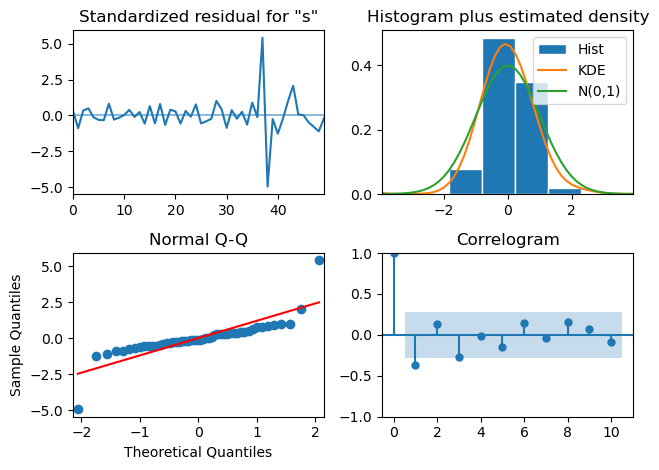

In [96]:
# Print model summary and MSE
print(f"\nTest Set MSE: {arimax_mse}")
print("\nModel Summary:")
print(arimax_result.summary())

# Plot model diagnostics
arimax_result.plot_diagnostics()
plt.tight_layout()
plt.show()


The Mean Squared Error (MSE) of 0.28, which is slightly higher than the previous model, it’s clear this model sacrifices some short-term precision for a simpler, upward trend. However, given the purpose of capturing a long-term forecast, this model's upward trend might indeed be more realistic for projecting future impacts on a broad timescale. Since the MSE here is slightly higher than the previous model, it suggests that this model may not fit the historical data as closely. However, the upward trend here might better match expectations of future conditions given known patterns of increasing fire frequency and intensity.

**More Model Summary Insights:** 
The standardized residuals plot indicates some deviations from normality, particularly with a few outliers. The histogram and KDE density plot suggest that residuals are mostly centered around zero but may deviate from a normal distribution. The Normal Q-Q plot shows a general linear trend, with some points deviating from the line, indicating potential non-normality in the residuals. The correlogram suggests a lack of significant autocorrelation, with most lags close to zero. Significant predictors include Circleness_Scale, peak_daily_impact, and num_fires, which have statistically significant coefficients. The model presents high kurtosis and heteroskedasticity, as shown by the Jarque-Bera and Heteroskedasticity tests, suggesting that the residuals have heavy tails and variance instability.


Based on this judgement, I decided that the ARIMAX model is better than the ARIMA model.